## GAN이란

비지도학습이며 `Generator`와 `Discriminator`가 서로 경쟁하며 가짜와 진짜를 구분하려고 노력하고 또 속이려고 노력하는 모델이다.

`Generator`가 속이려고 노력하는 친구다.(위조범) <br/>
`Discriminator`가 가짜와 진짜를 구분하는 친구이다.(경찰)

`Generator`는 노이즈를 입력받아 `Discriminator`를 속이기 위한 방향으로 생성모델을 수정해나간다. 궁극적으로 Generator의 확률분포가 Real 데이터의 확률분포와의 차이를 줄여나가는 과정을 거친다 (best : 0.5)

`Discriminator`는 먼저 `Generator`와 기존 확률 분포가 얼마나 다른지 판단한다.

```
 P와 M과 / Q와 M을 각각 KLD하여 두 분포의 차이에서 평균 값을 구해 두 확률 분포 간의 차이를 구한다.

이러한 발산 과정을 통해, 원 데이터의 확률분포가 Generator가 생성한 확률분포인 Q 간의 JSD가 0이 되면 두 분포간 차이가 없다는 것으로 학습이 완료되며 GAN의 궁극적인 목표에 도달하게 된다.
```

## cGAN이란

앞에서 보았듯이 `GAN`에서 각 항에 y가 추가된 모델이다. 

여기서 y는 label을 뜻하고 MNIST 데이터셋을 본다면 0~9까지의 수를 뜻한다.

이를 통해 G와 D는 label의 정보를 추가로 얻게되고 이를 통해 서로 속이고 진짜가짜를 구별해내는 치열한 사투를 벌이게 된다.

#### 여기서 가장 핵심은 결국에는 서로 확률분포를 가지고 판단한다는 것이다.

## 1. Generator 구성하기
라이브러리 설치

`$` pip list | grep tensorflow-dataset <br/>
`$` pip install tensorflow-dataset

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /aiffel/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


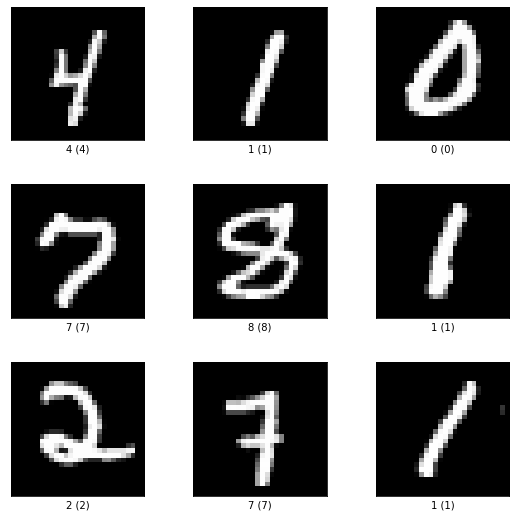

In [1]:
import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

1. 아래 코드를 실행해서 학습 전에 `필요한 몇가지 처리를 수행하는 함수를 정의`한다.

2. 이미지 픽셀 값을 `-1~1 사이의 범위로 변경`했고, 레이블 정보를 `원-핫 인코딩` 했다.

3. GAN과 cGAN 각각 실험하기 위해 label 정보 사용 유무에 따라서 `gan_preprocessing()`과 `cgan_preprocessing()` 두 함수를 구성한다.

In [2]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")

✅


Label : tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


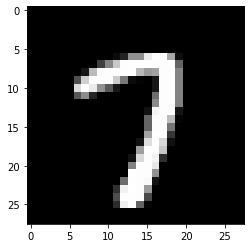

In [3]:
# 원하는대로 처리되었는지 한개만 선택해서 확인해본다.
# 숫자와 레이블이 일치해야하고 이미지의 범위가 -1~1 사이에 있어야된다.
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

### GAN Generator 구성하기

1. Tensorflow2의 Subclassing 방법을 이용한다.  


2. `Subclassing` 방법은 `tensorflow.keras.Model` 을 상속받아 클래스를 만들고, 일반적으로 `__init()` 메서드 안에서 레이어 구성을 정의하고, 구성된 레이어를 `call()` 메서드에서 사용해 forward propagation을 진행한다.  


3. Pytorch 모델 구성 방법과 매우 유사하므로 익히면 Pytorch에서도 빠르게 습득할 수 있다. 

In [4]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅")

✅


1. `__init__()` 메서드 안에서 사용할 모든 레이어를 정의했다.  
2. 4개의 `fully-connected` 레이어 중 한개를 제외하고 모두 ReLU 활성화를 사용했다.  

3. `call()` 메서드는 노이즈를 입력받아서 init에서 정의된 레이어들을 순서대로 통과한다.  

#### Generator는 숫자가 쓰인 이미지를 출력해야되서 마지막 출력은 (28.28.1) 크기로 변환한다.

### cGAN Generator 구성하기

In [5]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


#### Generator 구성하기 정리

1. 노이즈 입력 및 레이블 입력은 각각 1개의 fully-connected 레이어와 ReLU 활성화를 통과합니다. (dense_z, dense_y)  


2. 1번 문항의 각 결과가 서로 연결되어 다시 한번 1개의 fully-connected 레이어와 ReLU 활성화를 통과합니다 (tf.concat, conbined_dense)  


3. 2번 문항의 결과가 1개의 fully-connected 레이어 및 Hyperbolic tangent 활성화를 거쳐 28x28 차원의 결과가 생성되고 (28,28,1) 크기의 이미지 형태로 변환되어 출력됩니다 (final_dense, reshape)

## 2. Discriminator 구성하기

### GAN Discriminator 구성하기

In [6]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


1. `__init__()`에 `blocks`라는 리스트를 만들어 놓고 for loop를 이용해 레이어들을 쌓았다. 이 방식을 통해 각각 fully-connected 레이어를 매번 정의하지 않아도 되므로 많은 레이어가 필요할 때 편리하다.  


2. fully-connected 레이어로 학습하기 위해 `call()`에서는 먼저 `layers.Flatten()`이 적용된다.  


3. 레이어들이 쌓여있는 `blocks`에 대해서 for loop를 이용해 레이어들을 순서대로 하나씩 꺼내서 입력 데이터를 통과시킨다.  


4. 마지막으로 fully-connected 레이어를 통과하면 진짜 가짜 이미지를 나타내는 1개의 값이 나오게 된다.

### cGAN Discriminator 구성하기

`cGAN의 Discriminator`는 `Maxout`이라는 특별한 레이어가 사용된다.

`Maxout`이란 두 레이어 사이를 연결할 때, 여러 개의 fully-connected 레이어를 통과시켜서 가장 큰 값을 가져오도록 한다. 

In [7]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)

print("✅")

✅


`Maxout` 레이어를 구성할 때 `units`과 `pieces`의 설정이 필요하고, units 차원 수를 가진 fully-connected 레이어를 `pieces개만큼 만들고 그중 최댓값을 출력`한다. 

예를 들어서 `units=100`, `pieces=10`으로 설정했다면 입력으로부터 100차원의 representation을 10개 만들고, 그 10개 중에서 최대값을 가져와서 그 최대값의 100차원 representation이 출력된다.

이 `Maxout` 레이어를 3번만 사용하면 cGAN의 `Discriminator`를 구성할 수 있다.

In [8]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")

✅


## 3. 학습 및 테스트하기

1.  GAN, cGAN 각각의 모델 학습에 공통적으로 필요한 `loss function과 optimizer를 정의`한다.  


2. 진짜 및 가짜를 구별하기 위해 `Binary Cross Entropy`를 사용하고, `Adam optimizer`를 이용해 학습한다.

In [9]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

print("✅")

✅


### GAN으로 MNIST 학습하기

입력으로 사용되는 노이즈는 100차원으로 설정

In [10]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

print("✅")

✅


In [11]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.1443943977355957, D:0.14067015051841736
[1/10 EPOCHS, 200 ITER] G:2.6676552295684814, D:0.0903373435139656
[1/10 EPOCHS, 300 ITER] G:2.1380414962768555, D:0.17092040181159973
[1/10 EPOCHS, 400 ITER] G:3.0751070976257324, D:0.2561926245689392
[2/10 EPOCHS, 100 ITER] G:4.217724800109863, D:0.04550614953041077
[2/10 EPOCHS, 200 ITER] G:3.6631357669830322, D:0.08343974500894547
[2/10 EPOCHS, 300 ITER] G:3.9384636878967285, D:0.13474012911319733
[2/10 EPOCHS, 400 ITER] G:3.884765148162842, D:0.109180748462677
[3/10 EPOCHS, 100 ITER] G:2.4431300163269043, D:0.2826429605484009
[3/10 EPOCHS, 200 ITER] G:2.878753423690796, D:0.18262742459774017
[3/10 EPOCHS, 300 ITER] G:4.148313522338867, D:0.1333719789981842
[3/10 EPOCHS, 400 ITER] G:3.516209125518799, D:0.14076317846775055
[4/10 EPOCHS, 100 ITER] G:4.093113899230957, D:0.06915882974863052
[4/10 EPOCHS, 200 ITER] G:4.585437774658203, D:0.053028032183647156
[4/10 EPOCHS, 300 ITER] G:4.0385870933532715, D:0.1256933659

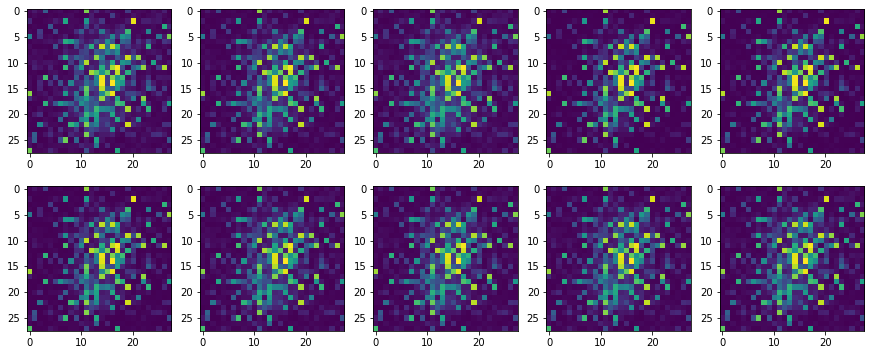

In [12]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

#### 10 epochs의 학습만으로는 좋은 결과를 볼 수 없었다.

#### 준비된 500 epochs만큼 학습한 가중치를 사용해본다.

`$` mkdir -p ~/aiffel/conditional_generation/gan 

`$` cp ~/data/gan/GAN_500.zip 
~/aiffel/conditional_generation/gan/

`$` cd ~/aiffel/conditional_generation/gan && unzip GAN_500.zip

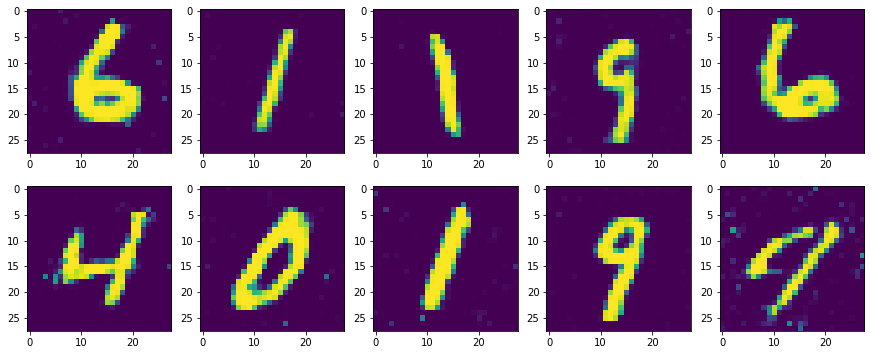

In [13]:
import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

### cGAN으로 MNIST 학습하기

이전 단계에서 구성한 `GeneratorCGAN` 및 `DiscriminatorCGAN` 모델 클래스를 이용한다.

In [14]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:6.202934265136719, D:0.002363927662372589
[1/1 EPOCHS, 199 ITER] G:4.828434944152832, D:0.04047326743602753
[1/1 EPOCHS, 299 ITER] G:4.559773921966553, D:0.02143770456314087
[1/1 EPOCHS, 399 ITER] G:5.1907758712768555, D:0.025788553059101105


Generator 및 Discriminator에 레이블 정보만 추가로 입력했다는 점을 제외하면 위에서 학습한 GAN과 큰 차이가 없다.

500 epochs 학습한 가중치를 사용하기 위해 작업환경을 구성한다.

`$` mkdir -p ~/aiffel/conditional_generation/cgan

`$` cp ~/data/cgan/CGAN_500.zip ~/aiffel/conditional_generation/cgan/

`$` cd ~/aiffel/conditional_generation/cgan && unzip CGAN_500.zip

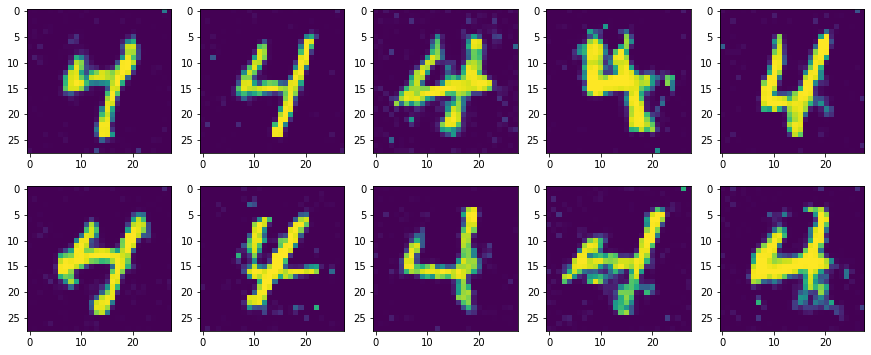

In [15]:
number = 4  # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

## 4. GAN의 입력에 이미지를 넣는다면? Pix2Pix

`Pix2Pix`는 기존 노이즈 입력을 이미지로 변환하는 일반적인 GAN이 아니라, `이미지를 입력으로 하여 원하는 다른 형태의 이미지로 변환`시킬 수 있는 GAN 모델이다.

`Image-to-Image Translation`은 말 그대로 이미지 간 변환이다.

이 `Pix2Pix`구조는 최근 활발하게 연구 및 응용되는 GAN 기반의 Image-to-Image Translation 작업에서 가장 기초가 되는 연구이다.

#### 이미지 변환이 목적인 `Pix2Pix`는 이미지를 다루는데 효율적인 convolution 레이어를 활용한다.

#### GAN 구조가 기반이기 때문에 Generator와 Discriminator 두가지 구성요소로 이루어진다.

`Generator`는 어떤 이미지를 입력 받아 변환된 이미지를 출력하기 위해 사용된다. Encoder-Decoder 구조이다.

## 5. 난 스케치를 할 테니 너는 채색을 하거라 : 데이터 준비하기

pix2pix 모델을 직접 구현하고 실험해본다. `Sketch2Pokemon`이라는 데이터셋을 사용한다.

830개의 이미지가 있으며, 각 (256x256) 크기의 이미지 쌍이 나란히 붙어 (256x512) 크기의 이미지로 구성되어 있다.

학습용 데이터셋만 따로 가져왔다고 한다.(데이터 불러오기)

`$` mkdir -p ~/aiffel/conditional_generation/data

`$` ln -s ~/data/sketch2pokemon.zip ~/aiffel/conditional_generation/data

`$` cd ~/aiffel/conditional_generation/data && unzip sketch2pokemon.zip

In [16]:
import os

data_path = os.getenv('HOME')+'/aiffel/conditional_generation/data/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


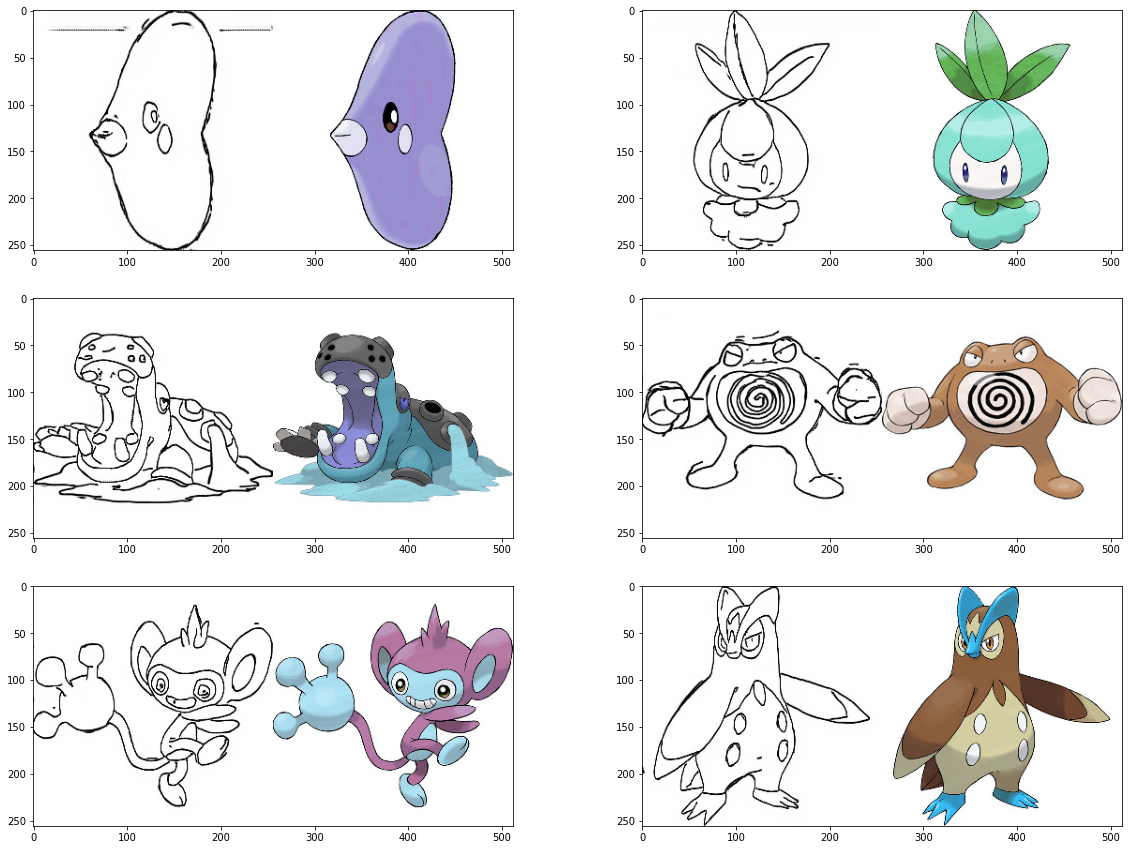

In [17]:
# 임의의 6장을 선택해 시각화한다.
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [18]:
# 이미지의 크기를 확인해본다.
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


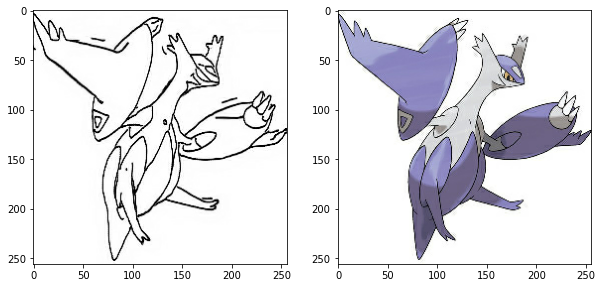

In [19]:
# 모델 학습에 사용할 데이터를 (256,256,3) 크기의 2개 이미지로 분할한다.
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [20]:
# Pix2Pix 모델을 사용해 채색된 이미지를 생성하는 것이 목표이다.
# 데이터의 다양성을 높이기 위해 여러 augmentation 방법을 적용한다.
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


1. 두 이미지가 채널 축으로 연결됩니다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 됩니다.  


2. 1.의 결과에 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼적용됩니다. (tf.pad)  


3. 2.의 결과에서 (256,256,6) 크기를 가진 이미지를 임의로 잘라냅니다. (tf.image.random_crop)  


4. 3.의 결과를 50% 확률로 가로로 뒤집습니다. (tf.image.random_flip_left_right)  


5. 4.의 결과를 50% 확률로 세로로 뒤집습니다. (tf.image.random_flip_up_down)  


6. 5.의 결과를 50% 확률로 회전시킵니다. (tf.image.rot90)

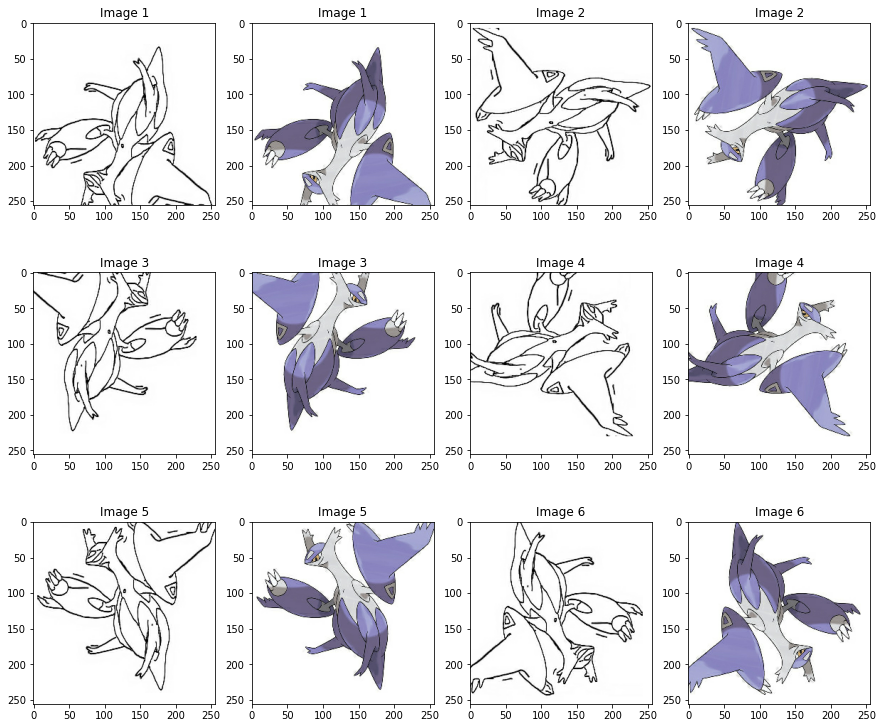

In [21]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

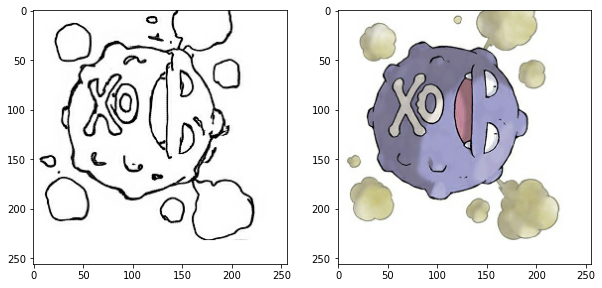

In [22]:
# 하나의 이미지만 시각화하여 확인해본다.
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 6. 난 스케치를 할 테니 너는 채색을 하거라  : Generator 구성하기

### Generator의 구성요소 알아보기

`encoder의 C64의 하이퍼파라미터 레이어 조합`
 - 64개의 4x4 필터에 stride 2를 적용한 Convolution → 0.2 slope의 LeakyReLU (위 논문의 아래 단락에 BatchNorm을 사용하지 않는다고 쓰여 있습니다)
 
`deoder의 C512의 하이퍼파라미터 레이어 조합`
 - 512개의 4x4 필터에 stride 2를 적용한 (Transposed) Convolution → BatchNorm → 50% Dropout → ReLU
 
### Generator 구현하기

Generator의 Encoder 부분 구현해본다.
 - "C64", "C128" 등으로 쓰여진 것과 같이 "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 블록들을 아래와 같이 하나의 레이어로 만들어본다.

In [23]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

print("✅")

✅


1. __init__() 메서드에서 `n_filters`, `use_bn`를 설정해서 사용할 필터의 개수와 BatchNorm 사용 여부를 결정할 수 있다.  


2.  Convolution 레이어에서 필터의 크기(=4) 및 stride(=2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용할 수 있도록 값을 지정했다.  

In [24]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


#### 설명

1. 각 블록을 거치면서 사용할 필터 개수를 `filters`라는 리스트에 지정해 두었고 `blocks`라는 리스트에 사용할 블록들을 정의해 두었고, `call()` 메서드에서 차례대로 블록을 통과한다.  

2. `Encoder` 첫번째 블록에서는 BatchNorm을 사용하지 않는다.  

3. `get_summary`는 레이어가 제대로 구성되었는지 확인하기 위한 용도로 따로 만들었다.  


위에서 구성한 Encoder에 (256,256,3) 크기의 데이터를 입력했을 때, 어떤 크기의 데이터가 출력되는지 보자.

In [25]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

1. 블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나서 (1,1,512)로 알맞는 크기가 출력된다.  

Decoder도 Encoder와 마찬가지로 사용할 기본 블록을 정의하고, 블록을 여러 번 반복하여서 아래와 같이 Decoder로 만든다.

In [26]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        
print("✅")

✅


세 개의 블록에서만 `Dropout`을 사용했고, 마지막 convolution에는 3개의 필터를 사용해서 출력한다.

(1,1,512) 크기의 데이터가 입력되었을 경우, 어떤 크기가 출력되는지 확인해본다.

In [27]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

1. Encoder와 Decoder를 연결시키면 Encoder에서 (256,256,3) 입력이 (1,1,512)로 변환된다.  

2. Decoder를 통과해 다시 원래 입력 크기와 같은 (256,256,3)의 결과를 얻을 수 있게된다.  

`tf.keras.Model`을 상속받아 Encoder와 Decoder를 연결해 `Generator를 구성`해본다.

In [28]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


## 7. 난 스케치를 할 테니 너는 채색을 하거라 : Generator 재구성하기

In [29]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


#### U-Net Generator 정의하기

1. __init__() 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의한다.  


2. 그 후 call()에서 forward propagation 하도록 합니다  


3. 이전 구현에는 없었던 skip connection이 call() 내부에서 어떻게 구현되었는지 확인해본다.

In [30]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


#### 알고리즘 흐름 이해하기

1. `__init__()` 에서 정의된 encode_blocks 및 decode_blocks가 `call() 내부`에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행한다.  


2. Encoder와 Decoder 사이의 skip connection을 위해 `features` 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담는다.  


3.  Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과한다.  


4. 이때 `features` 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용된다.

In [31]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

## 8. 난 스케치를 할 테니 너는 채색을 하거라 : Discriminator 구성하기

Generator만으로는 좋은 결과를 도출하기 힘들기 때문에 조금 더 사실적인 이미지를 생성하기 위해서 Discriminator를 만들어서 Pix2Pix 구조를 완성시킨다.


### Discriminator의 구성요소 알아보기

1. Discriminator는 2개 입력 (ex. `in` or `unknown`)을 받아 연결(concat)한 후, `Encode`라고 쓰인 5개 블록을 통과한다.  


2. 마지막 블록은 1(채널)차원 출력을 위한 블록이 추가된다.  


3. 최종적인 출력의 크기는 (30,30,1)이고, 위 그림의 출력 이전에 2개의 Encode 블록을 보면 각각 출력 크기가 32, 31, 30으로 1씩 감소하게된다.  


4. 그 이유는 앞서 Discriminator에서 봤던 70X70 PatchGAN을 사용했기 때문이다. 최종 30,30출력에서 각 픽셀의 receptive field 크기를 70,70으로 맞추기 위해서 Discriminator의 출력 크기를 30,30으로 강제로 맞추는 과정이다.  


### Discriminator 구현하기

In [32]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


필터의 수(n_filters), 필터가 순회하는 간격(stride), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad), BatchNorm의 사용 여부(use_bn), 활성화 함수 사용 여부(act)가 설정 가능하다.

#### Q. 위에서 만든 DiscBlock의 설정을 다음과 같이 하여 DiscBlock(n_filters=64, stride=1, custom_pad=True, use_bn=True, act=True) 으로 생성된 블록에 (width, height, channel) = (128, 128, 32) 크기가 입력된다면, 블록 내부에서 순서대로 어떠한 레이어를 통과하는지, 그리고 각 레이어를 통과했을 때 출력 크기는 어떻게 되는지 적어주세요.

1. 패딩 레이어 통과 layers.ZeroPadding2D() → (130,130,32)  


2. Convolution 레이어 통과 layers.Conv2D(64,4,1,"valid") → (127,127,64)  


2. BatchNormalization 레이어 통과 layers.BatchNormalization() → (127,127,64)  


3. LeakyReLU 활성화 레이어 통과 layers.LeakyReLU(0.2) → (127,127,64)  


#### 세부내용 설명 ↓

1. (128,128,32) 크기의 입력이 layers.ZeroPadding2D()를 통과하면, width 및 height의 양쪽 면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어납니다. 출력 : (130,130,32)  


2. 패딩하지 않고 필터 크기 4 및 간격(stride) 1의 convolution 레이어를 통과하면 width 및 height 가 3씩 줄어듭니다. 이는 OutSize=(InSize+2∗PadSize−FilterSize)/Stride+1 의 식으로 계산할 수 있습니다. 채널 수는 사용한 필터 개수와 같습니다. 출력 : (127,127,64)  


3. 이 외 다른 레이어(BatchNorm, LeakyReLU)는 출력의 크기에 영향을 주지 않습니다.

In [33]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [34]:
# Discriminator 만들기
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [35]:
# 첫번째 블록은 단순한 연결(concat)을 수행한다.
# Discriminator 최종 출력은 sigmoid 활성화를 사용했다.
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

1. 두 개의 (256,256,3) 크기 입력으로 최종 (30,30,1) 출력을 만들었고, 아래의 Discriminator를 나타낸 그림과 각 출력 크기가 일치한다.  


2. 임의의 (256,256,3) 크기의 입력을 넣어 나오는 (30,30) 출력을 시각화해본다.

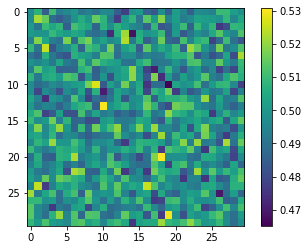

In [36]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 9. 난 스케치를 할 테니 너는 채색을 하거라  : 학습 및 테스트하기

GAN 손실 함수에 L1을 추가로 이용해서 두가지 손실 함수를 모두 사용한다.

In [37]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


### Generator 및 Discriminator의 손실 계산을 각각 정의했다.

1. Generator의 손실 함수 (위 코드의 get_gene_loss)는 총 3개의 입력이 있다.  
 - fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이다.
 - 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용한다.
 - L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산한다.  
 
 
2. Discriminator의 손실 함수 (위 코드의 get_disc_loss)는 2개의 입력이 있다.  
 - Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교한다.

In [38]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [39]:
# 하나의 배치 크기만큼 데이터 입력했을 때 가중치를 1회 업데이트 하는 과정이다.
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


#### 여기서 짚고 나가야할 점이 있다.

위 코드의 `gene_total_loss` 계산 라인에서 최종 Generator 손실을 계산할 때, L1 손실에 100을 곱한 부분이 있다.

논문에서는 Generator의 손실을 정의했는데 `세타`는 학습과정에서 L1 손실을 얼마나 반영할 것인지를 나타내고 논문에서는 `λ=100`를 사용했다.

In [40]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.8897                     
L1_loss:0.4626                     
Discriminator_loss:1.1976

EPOCH[1] - STEP[20]                     
Generator_loss:1.3626                     
L1_loss:0.3050                     
Discriminator_loss:1.5317

EPOCH[1] - STEP[30]                     
Generator_loss:1.2398                     
L1_loss:0.2627                     
Discriminator_loss:1.1808

EPOCH[1] - STEP[40]                     
Generator_loss:1.1764                     
L1_loss:0.2301                     
Discriminator_loss:1.0745

EPOCH[1] - STEP[50]                     
Generator_loss:0.9784                     
L1_loss:0.2812                     
Discriminator_loss:0.9406

EPOCH[1] - STEP[60]                     
Generator_loss:1.1806                     
L1_loss:0.3597                     
Discriminator_loss:0.8317

EPOCH[1] - STEP[70]                     
Generator_loss:1.5322                     
L1_loss:0.2779                    

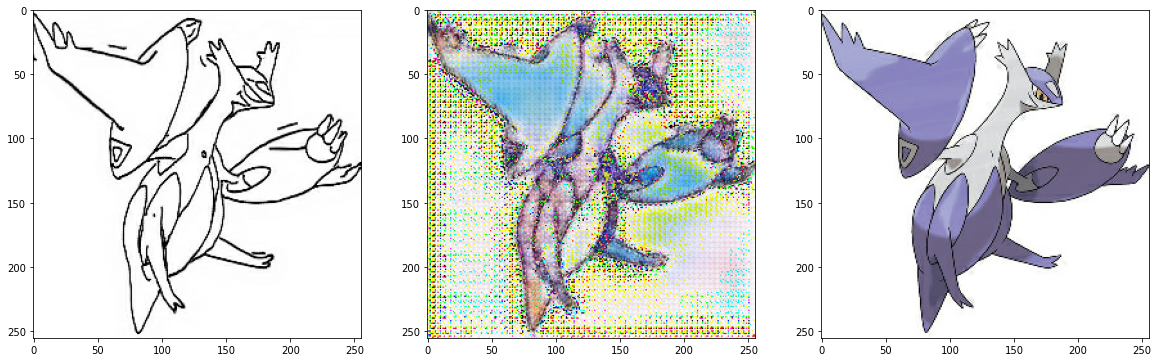

In [41]:
# 채색 입히기
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))